In [11]:
import pandas as pd

data = pd.read_csv('../DataIntermediate/merged_data_cafine.csv', sep = ',')
data.rename(columns={
    'b1_1': 'Clay+Silt Raster',
    'b2_1': 'Sand Raster',
    'b3_1': 'Silt Raster',
    'b4_1': 'Clay Raster',
    'Unnamed: 0': 'Id'
}, inplace=True)

data.head()

,Id,NDVI,SR,GCVI,NDWI,VARI,GNDVI,GRVI,SAVI,VSSI,...,YNSI2_G2,YNInt2_G1,YNInt2_G2,YNNDSI,YNNDVI,Clay+Silt Raster,Sand Raster,Silt Raster,Clay Raster,SAR
0,0,0.364127,2.145283,2.336546,-0.538803,-0.330611,0.538803,3.336546,0.242722,-19060.0,...,2029.7554,1708.75,1740.25,0.031445,-0.031445,0.000000,0.000000,0.000000,0.000000,26.926614
1,1,0.439585,2.568796,2.107235,-0.513050,-0.154374,0.513050,3.107235,0.293014,-15495.0,...,1662.3491,1401.75,1432.25,-0.059287,0.059287,0.519413,0.473399,0.337390,0.181547,86.327645
2,2,0.508677,3.070660,2.571547,-0.562505,-0.128842,0.562505,3.571547,0.339072,-16807.0,...,1604.8911,1356.50,1383.25,-0.074180,0.074180,0.654887,0.343329,0.461192,0.192468,112.754286
3,3,0.416839,2.429589,1.797036,-0.473273,-0.125389,0.473273,2.797036,0.277851,-15069.5,...,1722.4656,1465.75,1484.50,-0.059602,0.059602,0.524789,0.470715,0.431571,0.093336,193.130080
4,4,0.354755,2.100475,1.346602,-0.402379,-0.109266,0.402379,2.346602,0.236459,-11940.0,...,1522.3079,1291.25,1314.25,-0.048999,0.048999,0.517817,0.474641,0.407218,0.110598,126.060248


In [12]:
# Select from data the index selected

data_for_model = data[['Id','YNNDSI', 'Clay Raster','YBS2','RS5_G2','SAR']]

data_for_model.head()

,Id,YNNDSI,Clay Raster,YBS2,RS5_G2,SAR
0,0,0.031445,0.000000,-0.031445,1253.3464,26.926614
1,1,-0.059287,0.181547,0.059287,1085.8315,86.327645
2,2,-0.074180,0.192468,0.074180,1095.6101,112.754286
3,3,-0.059602,0.093336,0.059602,1043.8142,193.130080
4,4,-0.048999,0.110598,0.048999,912.2394,126.060248


In [13]:
X = data_for_model[['YNNDSI', 'Clay Raster','YBS2','RS5_G2']]
y = data_for_model[['SAR']]

## CNN

Epoch [10/50], Train Loss: 29.778795268437634, Test Loss: 30.469740120140283
Epoch [20/50], Train Loss: 27.75690972315122, Test Loss: 26.587375847068994
Epoch [30/50], Train Loss: 27.64968535018294, Test Loss: 25.137431969513763
Epoch [40/50], Train Loss: 29.684046444827562, Test Loss: 24.854907654427194
Epoch [50/50], Train Loss: 27.7350111660892, Test Loss: 22.214883391921585


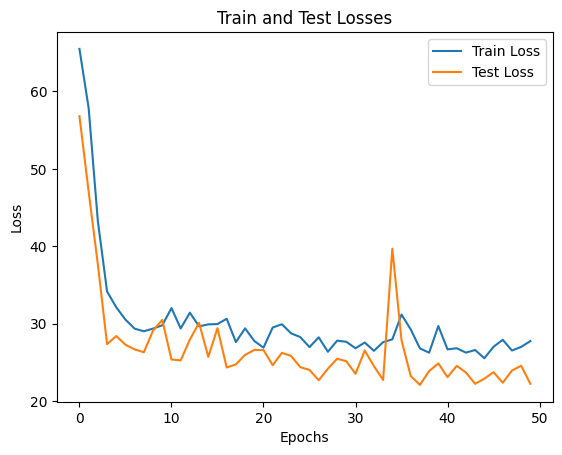

In [14]:
#@title CNN Cov-1D

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import  load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

list = ['YNNDSI', 'Clay Raster','YBS2','RS5_G2']

count = len(list)

# Definir parámetros del modelo
input_size = count  # Número de características
hidden_size = 132
batch_size = 32
num_epochs = 50
learning_rate = 0.1
regularization_param = 0.1
dropout_p = 0.01

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28) #21, 65 , 22, 24, 28*,33, 35, 49,53**,68,72**, (77 con 12 epocas)*,79,83, 92*

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.float32)  # Convertir a un tensor 1D
y_test_tensor = torch.tensor(y_test.values.flatten(), dtype=torch.float32)

# Crear conjuntos de datos y dataloaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc2 = nn.Linear(hidden_size * 1, hidden_size)  # El tamaño de la salida de la convolución es 4
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc5 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))  # Agregar dimensión de canal
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Aplanar la salida de la convolución
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Inicializar el modelo
model = CNN()

# Definir la función de pérdida y el optimizador
loss_fn =  nn.SmoothL1Loss() # Loss de regresión * MSELoss
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=regularization_param) # Adagrad, RMSprop

# Entrenamiento del modelo
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1))  # Añadir dimensión de salida
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dl.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1))  # Añadir dimensión de salida
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_dl.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss}, Test Loss: {test_loss}')

# Gráfico de pérdidas
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

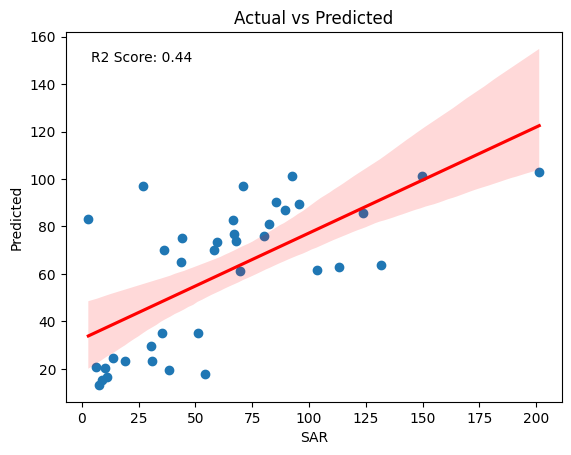

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Función para obtener las predicciones del modelo
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.extend(outputs.tolist())
    return predictions

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = get_predictions(model, test_dl)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Plotting the scatter plot
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")

# Adding the regression line
sns.regplot(x=y_test, y=y_pred, scatter=False, ax=ax, color='red')

# Adding the R2 score as annotation
ax.annotate(f'R2 Score: {r2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

plt.show()

In [30]:
# Obtener el summary del modelo
from torchsummary import summary
import numpy as np

summary(model, input_size=(4,))  # input_size debe ser el tamaño de la entrada de tus datos

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 132, 2]             528
       BatchNorm1d-2               [-1, 132, 2]             264
         MaxPool1d-3               [-1, 132, 1]               0
            Linear-4                  [-1, 132]          17,556
       BatchNorm1d-5                  [-1, 132]             264
            Linear-6                  [-1, 132]          17,556
       BatchNorm1d-7                  [-1, 132]             264
            Linear-8                  [-1, 132]          17,556
       BatchNorm1d-9                  [-1, 132]             264
          Dropout-10                  [-1, 132]               0
           Linear-11                    [-1, 1]             133


RuntimeError: Numpy is not available

In [32]:
torch.save(model.state_dict(), "../Final_work/Results/model.pth")

RuntimeError: Parent directory ../Final_work/Results does not exist.